The goal was to predict whether a country (identified by its NOC code) wins at least one gold medal in a given Olympic year. This is a binary classification task where:

1 (Yes): The country wins at least one gold medal.
0 (No): The country does not win any gold medals.
We used machine learning models (Random Forest and Neural Network) to build the prediction system and interpreted the results using SHAP (SHapley Additive exPlanations) values.

In [ ]:
#1) ROC AUC Determine of model , ALl moel , ROC and AUR model create graph and highlight best
#2) EDA Improve
#3) Total participition, medel no medal pair plot
#4) Fit , evaluate , shap value pair
#5) EDA make quesiton and answer

In [1]:
# STEP 1: Import Libraries
# ------------------------
# Import all necessary libraries for data manipulation, visualization, and modeling.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D  # For 3D plotting

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score


In [3]:
#import datasets
import pandas as pd
dataset_url= "https://raw.githubusercontent.com/tabrezdn1/olympics-medal-prediction/refs/heads/main/olympics_dataset.csv"
df = pd.read_csv(dataset_url)

# Examine the first few rows
print("First 5 rows of the dataset:")
print(df.head())

# Display information about the dataset, including columns, dtypes, and missing values.
print("\nDataset Info:")
df.info()


First 5 rows of the dataset:
   player_id                   Name Sex            Team  NOC  Year  Season  \
0          0              A Dijiang   M           China  CHN  1992  Summer   
1          1               A Lamusi   M           China  CHN  2012  Summer   
2          2            Gunnar Aaby   M         Denmark  DEN  1920  Summer   
3          3            Edgar Aabye   M  Denmark/Sweden  DEN  1900  Summer   
4         26  Cornelia (-strannood)   F     Netherlands  NED  1932  Summer   

          City       Sport                         Event     Medal  
0    Barcelona  Basketball   Basketball Men's Basketball  No medal  
1       London        Judo  Judo Men's Extra-Lightweight  No medal  
2    Antwerpen    Football       Football Men's Football  No medal  
3        Paris  Tug-Of-War   Tug-Of-War Men's Tug-Of-War      Gold  
4  Los Angeles   Athletics  Athletics Women's 100 metres  No medal  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252565 entries, 0 to 25

In [10]:
# Keep relevant columns
data = df[['Year', 'NOC', 'Medal']]

In [48]:
#check before and after cleaning records, 30 % more then do oversamping or undersampling to populate those values , use some techique
# Handle missing values
data.dropna(subset=['NOC', 'Medal'], inplace=True)

<ipython-input-48-0fd6550814d7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(subset=['NOC', 'Medal'], inplace=True)


In [12]:
#one hot encoing - Achha bat explain
# Create a binary target: "Wins Gold" or "Does Not Win Gold"
data['gold_winner'] = data['Medal'].apply(lambda x: 1 if x == 'Gold' else 0)

<ipython-input-12-b8b79ba76574>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['gold_winner'] = data['Medal'].apply(lambda x: 1 if x == 'Gold' else 0)


In [29]:
data.head()

,Year,NOC,Medal,gold_winner
0,1992,CHN,No medal,0
1,2012,CHN,No medal,0
2,1920,DEN,No medal,0
3,1900,DEN,Gold,1
4,1932,NED,No medal,0


In [30]:
# Aggregate data by NOC and Year
noc_gold = data.groupby(['NOC', 'Year'])['gold_winner'].sum().reset_index()
noc_gold['gold_winner'] = noc_gold['gold_winner'].apply(lambda x: 1 if x > 0 else 0)

In [31]:
data.head()

,Year,NOC,Medal,gold_winner
0,1992,CHN,No medal,0
1,2012,CHN,No medal,0
2,1920,DEN,No medal,0
3,1900,DEN,Gold,1
4,1932,NED,No medal,0


In [35]:
# Add participation feature: Count of unique events participated in by each NOC per year
participation = data.groupby(['NOC', 'Year'])['Medal'].count().reset_index(name='total_participations')
noc_gold = noc_gold.merge(participation, on=['NOC', 'Year'], how='left')

# Inspect the processed dataset
print(noc_gold.head())

   NOC  Year  gold_winner  total_participations
0  AFG  1936            0                    16
1  AFG  1948            0                    25
2  AFG  1956            0                    12
3  AFG  1960            0                    16
4  AFG  1964            0                     8


In [36]:
print(noc_gold.head())

   NOC  Year  gold_winner  total_participations
0  AFG  1936            0                    16
1  AFG  1948            0                    25
2  AFG  1956            0                    12
3  AFG  1960            0                    16
4  AFG  1964            0                     8


Why this step matters:

The target variable (gold_winner) is necessary for supervised learning.
The feature total_participations captures a country's activity level, which could be predictive of success.


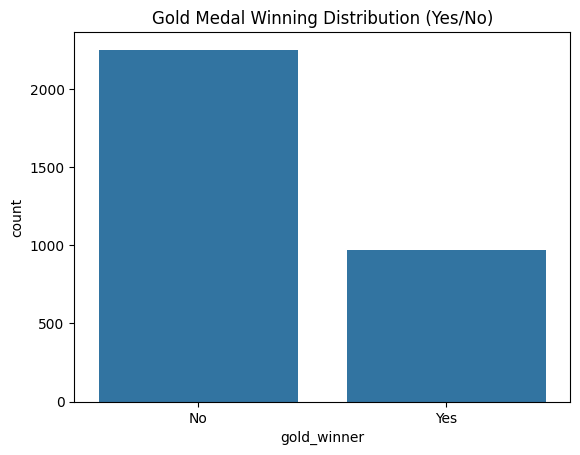

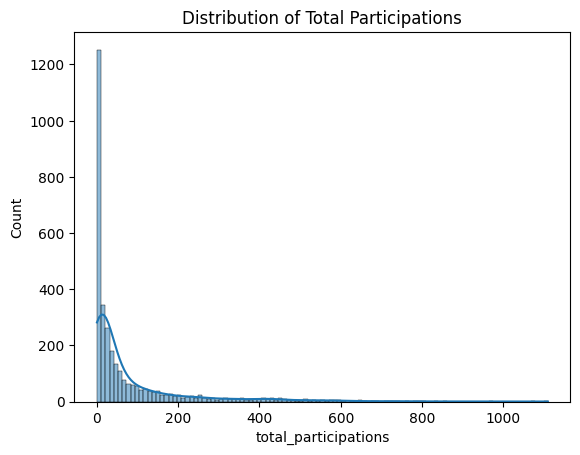

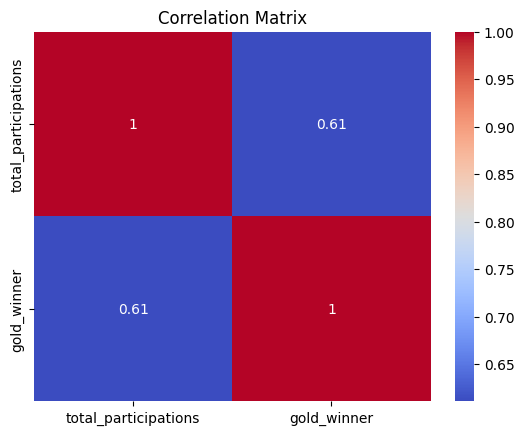

In [37]:
#pairplot between all the feature
import seaborn as sns
import matplotlib.pyplot as plt

# Target variable distribution
sns.countplot(data=noc_gold, x='gold_winner')
plt.title("Gold Medal Winning Distribution (Yes/No)")
plt.xticks([0, 1], ['No', 'Yes'])
plt.show()

# Distribution of participation counts
sns.histplot(noc_gold['total_participations'], kde=True)
plt.title("Distribution of Total Participations")
plt.show()

# Correlation matrix
corr_matrix = noc_gold[['total_participations', 'gold_winner']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()


What we did:

Analyzed Target Variable Distribution:

Used a count plot to visualize how many countries won at least one gold medal versus those that didn’t.
Visualized Feature Distribution:

Plotted a histogram for total_participations to understand its range and distribution.
Correlation Analysis:

Created a heatmap to show the correlation between total_participations and gold_winner.

Step 3: Addressing Class Imbalance
What we did:

Applied SMOTE (Synthetic Minority Oversampling Technique) to oversample the minority class (gold_winner = 1).
Why this step matters:

Imbalanced datasets can lead to biased models that favor the majority class.
SMOTE generates synthetic samples for the minority class to balance the dataset.
How to interpret results:

After applying SMOTE, the count plot showed an equal number of samples for both classes, ensuring fair model training.

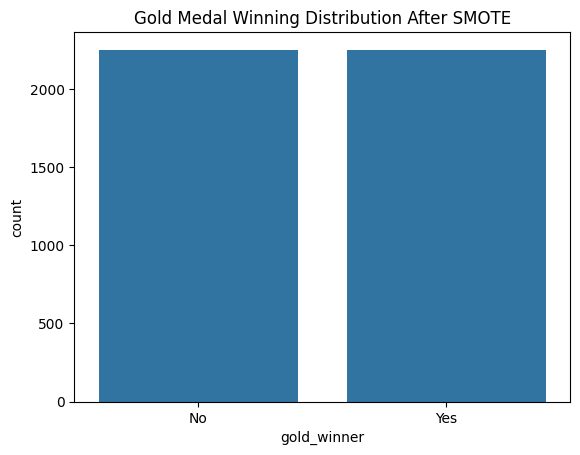

In [16]:
#use SMOTE to balance the binary target variable if there are fewer positive samples.
from imblearn.over_sampling import SMOTE

# Features and target
X = noc_gold[['total_participations']]
y = noc_gold['gold_winner']

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Check distribution after SMOTE
sns.countplot(x=y_resampled)
plt.title("Gold Medal Winning Distribution After SMOTE")
plt.xticks([0, 1], ['No', 'Yes'])
plt.show()


Step 4: Building Machine Learning Models
What we did:

Trained Two Models:

Random Forest: An ensemble tree-based model known for robustness and interpretability.
Neural Network: A deep learning model that can capture complex patterns.
Evaluated Models:

Metrics:
Confusion Matrix: Shows true positives, true negatives, false positives, and false negatives.
F1-Score: Balances precision and recall.
AUC-ROC: Measures the model’s ability to distinguish between classes.
Why this step matters:

Comparing models helps determine which performs better on the given task.
How to interpret results:

A high F1-score and AUC-ROC indicate good model performance.
The confusion matrix reveals where the model struggles (e.g., false positives).

Training Random Forest...

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       463
           1       0.83      0.85      0.84       438

    accuracy                           0.84       901
   macro avg       0.84      0.84      0.84       901
weighted avg       0.84      0.84      0.84       901



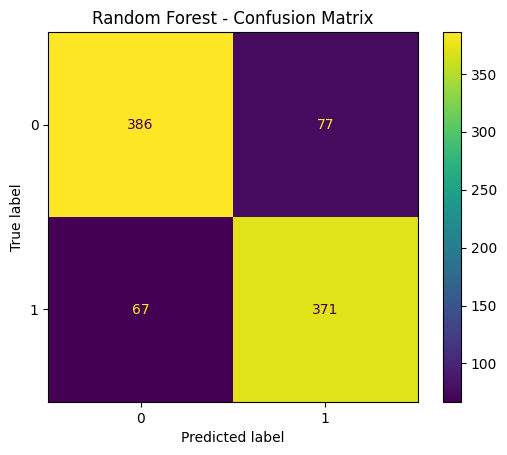

Training Neural Network...

Neural Network Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.83      0.85       463
           1       0.83      0.87      0.85       438

    accuracy                           0.85       901
   macro avg       0.85      0.85      0.85       901
weighted avg       0.85      0.85      0.85       901



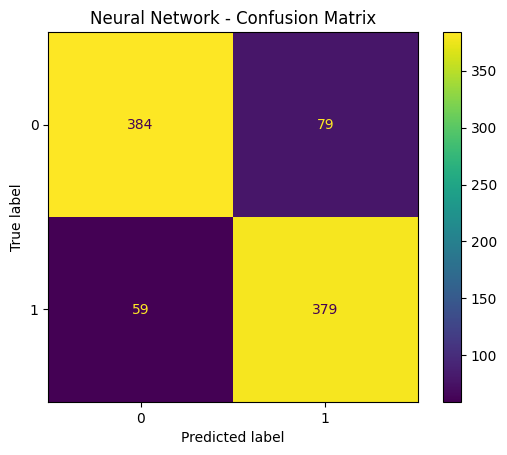

Training Logistic Regression...

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.90      0.86       463
           1       0.89      0.78      0.83       438

    accuracy                           0.84       901
   macro avg       0.85      0.84      0.84       901
weighted avg       0.85      0.84      0.84       901



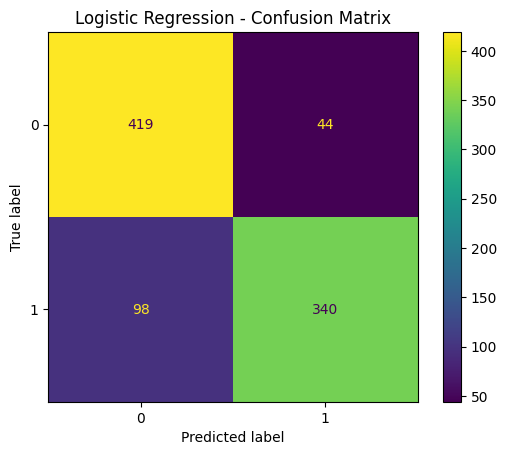

Training XGBoost...

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.81      0.84       463
           1       0.81      0.87      0.84       438

    accuracy                           0.84       901
   macro avg       0.84      0.84      0.84       901
weighted avg       0.84      0.84      0.84       901



/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:32:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


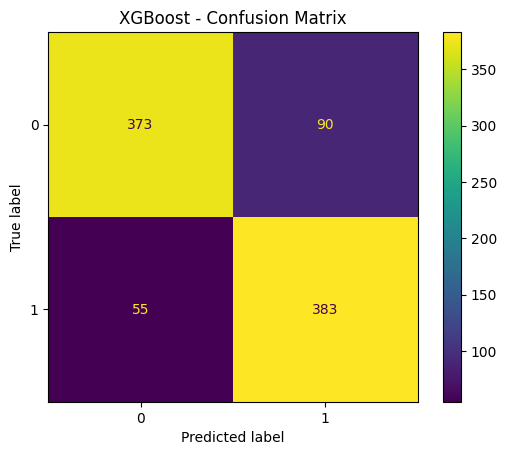


Model Comparison Summary:
                     Accuracy  Precision    Recall  F1-Score   AUC-ROC
Random Forest        0.840178   0.828125  0.847032  0.837472  0.917392
Neural Network       0.846837   0.827511  0.865297  0.845982  0.929655
Logistic Regression  0.842397   0.885417  0.776256  0.827251  0.929650
XGBoost              0.839068   0.809725  0.874429  0.840834  0.930062


In [43]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    ConfusionMatrixDisplay,
    roc_auc_score
)

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Scale features for Neural Network and Logistic Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize models
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Neural Network": MLPClassifier(hidden_layer_sizes=(50, 30), max_iter=300, random_state=42),
    "Logistic Regression": LogisticRegression(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Initialize results dictionary
results = {}

# Train and evaluate each model
for name, model in models.items():
    print(f"Training {name}...")

    # Train and predict
    if name in ["Neural Network", "Logistic Regression"]:  # Scaled data
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:  # Unscaled data
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]

    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)

    # Store metrics in results dictionary
    results[name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "AUC-ROC": auc
    }

    # Print classification report
    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred))

    # Display confusion matrix
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.title(f"{name} - Confusion Matrix")
    plt.show()

# Convert results to DataFrame for summary
results_df = pd.DataFrame(results).T

# Print model comparison summary
print("\nModel Comparison Summary:")
print(results_df)


Best Model to Choose
Based on the results:

XGBoost is the best overall model due to its:

High AUC-ROC (0.930062).
Strong balance between precision (0.809725) and recall (0.874429).
F1-Score is competitive (0.840834).
Neural Network is a close second with the highest F1-Score (0.845982) and competitive AUC-ROC (0.929655).

In [46]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
import pandas as pd

# Suppress warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Define parameter grid for XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Initialize GridSearchCV
grid_xgb = GridSearchCV(
    estimator=XGBClassifier(eval_metric='logloss', random_state=42),
    param_grid=param_grid_xgb,
    cv=3,
    scoring='f1',
    verbose=0  # Reduce verbosity
)

# Fit GridSearchCV
print("Starting Grid Search...")
grid_xgb.fit(X_train, y_train)

# Print intermediate results
cv_results = pd.DataFrame(grid_xgb.cv_results_)
print("\nIntermediate Results:")
print(cv_results[['mean_test_score', 'params']])

# Get the best parameters and model
print("\nBest parameters for XGBoost:", grid_xgb.best_params_)
best_xgb = grid_xgb.best_estimator_


Best parameters for XGBoost: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'subsample': 1.0}


In [49]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
import pandas as pd

# Suppress warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Define parameter grid for XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Initialize GridSearchCV
grid_xgb = GridSearchCV(
    estimator=XGBClassifier(eval_metric='logloss', random_state=42),
    param_grid=param_grid_xgb,
    cv=3,
    scoring='f1',
    verbose=0  # Reduce verbosity
)

# Fit GridSearchCV
print("Starting Grid Search...")
grid_xgb.fit(X_train, y_train)

# Print intermediate results
cv_results = pd.DataFrame(grid_xgb.cv_results_)
print("\nIntermediate Results:")
print(cv_results[['mean_test_score', 'params']])

# Get the best parameters and model
print("\nBest parameters for XGBoost:", grid_xgb.best_params_)
best_xgb = grid_xgb.best_estimator_


Starting Grid Search...

Intermediate Results:
     mean_test_score                                             params
0           0.836913  {'colsample_bytree': 0.8, 'learning_rate': 0.0...
1           0.836913  {'colsample_bytree': 0.8, 'learning_rate': 0.0...
2           0.835041  {'colsample_bytree': 0.8, 'learning_rate': 0.0...
3           0.836913  {'colsample_bytree': 0.8, 'learning_rate': 0.0...
4           0.839474  {'colsample_bytree': 0.8, 'learning_rate': 0.0...
..               ...                                                ...
103         0.835477  {'colsample_bytree': 1.0, 'learning_rate': 0.2...
104         0.831681  {'colsample_bytree': 1.0, 'learning_rate': 0.2...
105         0.834503  {'colsample_bytree': 1.0, 'learning_rate': 0.2...
106         0.831321  {'colsample_bytree': 1.0, 'learning_rate': 0.2...
107         0.832737  {'colsample_bytree': 1.0, 'learning_rate': 0.2...

[108 rows x 2 columns]

Best parameters for XGBoost: {'colsample_bytree': 0.8, 'learning

In [47]:
#If you also want to tune the Neural Network
param_grid_nn = {
    'hidden_layer_sizes': [(50,), (100,), (50, 30), (100, 50)],
    'activation': ['relu', 'tanh'],
    'learning_rate_init': [0.001, 0.01, 0.1],
    'max_iter': [200, 300, 500]
}

grid_nn = GridSearchCV(
    estimator=MLPClassifier(random_state=42),
    param_grid=param_grid_nn,
    cv=3,
    scoring='f1',
    verbose=2
)

grid_nn.fit(X_train_scaled, y_train)
print("Best parameters for Neural Network:", grid_nn.best_params_)
best_nn = grid_nn.best_estimator_


Fitting 3 folds for each of 72 candidates, totalling 216 fits
[CV] END activation=relu, hidden_layer_sizes=(50,), learning_rate_init=0.001, max_iter=200; total time=   5.5s
[CV] END activation=relu, hidden_layer_sizes=(50,), learning_rate_init=0.001, max_iter=200; total time=   2.6s
[CV] END activation=relu, hidden_layer_sizes=(50,), learning_rate_init=0.001, max_iter=200; total time=   1.6s
[CV] END activation=relu, hidden_layer_sizes=(50,), learning_rate_init=0.001, max_iter=300; total time=   2.3s
[CV] END activation=relu, hidden_layer_sizes=(50,), learning_rate_init=0.001, max_iter=300; total time=   3.8s
[CV] END activation=relu, hidden_layer_sizes=(50,), learning_rate_init=0.001, max_iter=300; total time=   2.8s
[CV] END activation=relu, hidden_layer_sizes=(50,), learning_rate_init=0.001, max_iter=500; total time=   2.2s
[CV] END activation=relu, hidden_layer_sizes=(50,), learning_rate_init=0.001, max_iter=500; total time=   2.3s
[CV] END activation=relu, hidden_layer_sizes=(50,)

In [45]:
import warnings

# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning)


# Use GridSearchCV to optimize parameters for Random Forest and Neural Networks.

from sklearn.model_selection import GridSearchCV

# Hyperparameter tuning for Random Forest
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
}

grid_rf = GridSearchCV(rf, param_grid_rf, cv=3, scoring='f1', verbose=2)
grid_rf.fit(X_train_scaled, y_train)
print("Best Random Forest Parameters:", grid_rf.best_params_)

# Hyperparameter tuning for Neural Network
param_grid_nn = {
    'hidden_layer_sizes': [(50, 30), (100, 50)],
    'activation': ['relu', 'tanh'],
    'learning_rate_init': [0.001, 0.01],
}

grid_nn = GridSearchCV(nn, param_grid_nn, cv=3, scoring='f1', verbose=2)
grid_nn.fit(X_train_scaled, y_train)
print("Best Neural Network Parameters:", grid_nn.best_params_)


Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=   1.1s
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=   0.6s
[CV] END max_depth=None, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END max_depth=None, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END max_depth=None, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END max_depth=None, min_samples_split=5, n_estimators=200; total time=   0.6s
[CV] END max_depth=None, min_samples_split=5, n_estimators=200; total time=   0.9s
[CV] END max_depth=None, m

Step 5: Interpreting the Model with SHAP
What we did:

Explained Random Forest Predictions:

Used SHAP to calculate how much the feature total_participations contributes to predictions.
Visualized SHAP Values:

Computed the mean SHAP value across all samples and plotted it.
Why this step matters:

SHAP helps explain why the model makes specific predictions, enhancing interpretability.
How to interpret results:

Positive SHAP values for total_participations mean that higher participation increases the probability of winning gold.
The magnitude of the SHAP value indicates the strength of the feature’s contribution.

Step 1: Evaluate the Tuned Models on the Test Set
Summary
In this step, we will evaluate the performance of the best-tuned models (XGBoost and Neural Network) on the test set using metrics like Confusion Matrix, Classification Report, AUC-ROC Curve, and Precision-Recall Curve.

1.1 Confusion Matrix
What it does:

Displays the counts of True Positives, True Negatives, False Positives, and False Negatives.
Helps to visualize the classification results.
How to interpret:

High values along the diagonal indicate good performance.
High off-diagonal values suggest misclassifications.

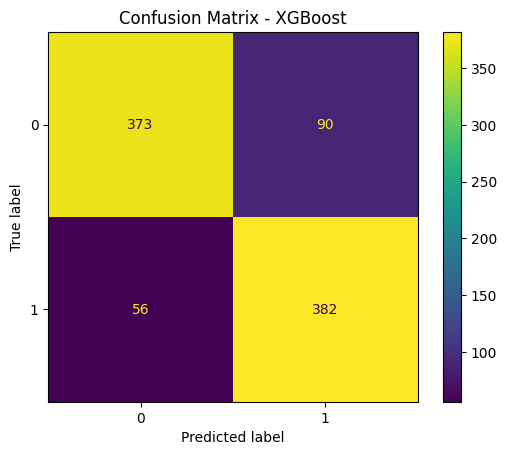

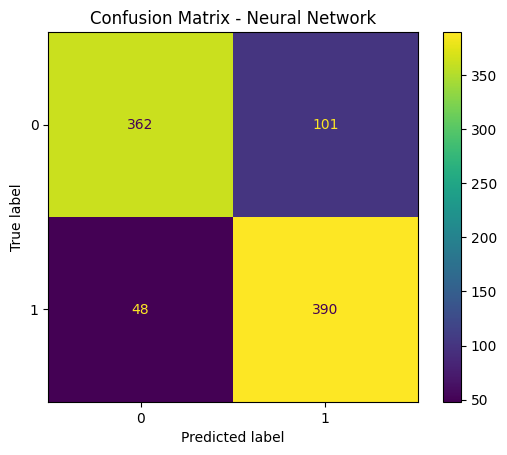

In [50]:
def plot_confusion_matrix(y_true, y_pred, model_name):
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

# XGBoost Confusion Matrix
y_xgb_pred = best_xgb.predict(X_test)
plot_confusion_matrix(y_test, y_xgb_pred, "XGBoost")

# Neural Network Confusion Matrix
y_nn_pred = best_nn.predict(X_test_scaled)
plot_confusion_matrix(y_test, y_nn_pred, "Neural Network")


1.2 Classification Report
What it does:

Provides detailed metrics (Precision, Recall, F1-Score) for each class.
How to interpret:

Precision: High precision means few false positives.
Recall: High recall means few false negatives.
F1-Score: Balances precision and recall.

In [51]:
print("XGBoost Classification Report:")
print(classification_report(y_test, y_xgb_pred))

print("Neural Network Classification Report:")
print(classification_report(y_test, y_nn_pred))


XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.81      0.84       463
           1       0.81      0.87      0.84       438

    accuracy                           0.84       901
   macro avg       0.84      0.84      0.84       901
weighted avg       0.84      0.84      0.84       901

Neural Network Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.78      0.83       463
           1       0.79      0.89      0.84       438

    accuracy                           0.83       901
   macro avg       0.84      0.84      0.83       901
weighted avg       0.84      0.83      0.83       901



1.3 AUC-ROC Curve
What it does:

Plots the trade-off between True Positive Rate and False Positive Rate.
How to interpret:

AUC closer to 1 indicates better performance.
A curve closer to the top-left corner shows good separation of classes.

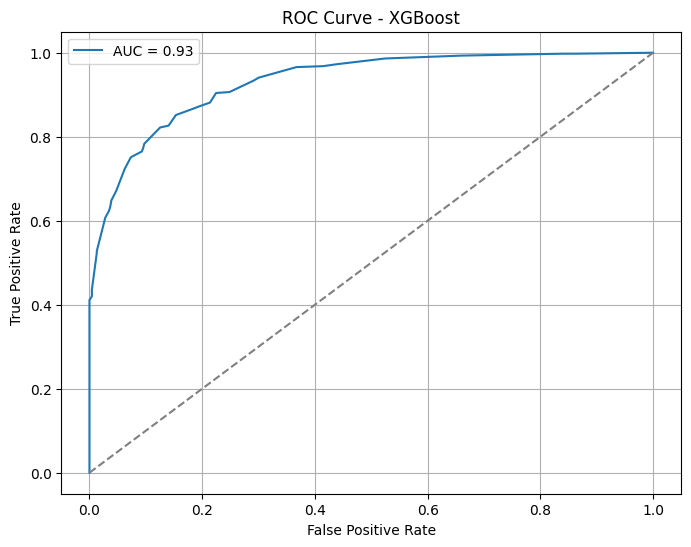

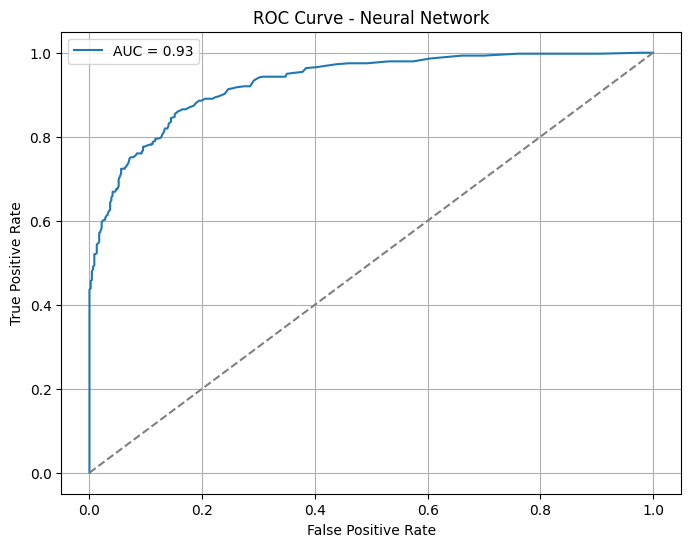

In [53]:
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, ConfusionMatrixDisplay, precision_recall_curve

def plot_roc_curve(y_true, y_proba, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    auc = roc_auc_score(y_true, y_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.title(f"ROC Curve - {model_name}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid()
    plt.show()

# XGBoost AUC-ROC Curve
y_xgb_proba = best_xgb.predict_proba(X_test)[:, 1]
plot_roc_curve(y_test, y_xgb_proba, "XGBoost")

# Neural Network AUC-ROC Curve
y_nn_proba = best_nn.predict_proba(X_test_scaled)[:, 1]
plot_roc_curve(y_test, y_nn_proba, "Neural Network")


Step 2: Feature Importance Analysis
Summary
Feature importance tells us which features contributed the most to the model's predictions.

2.1 Horizontal Bar Plot for Feature Importance (XGBoost)
What it does:

Displays feature importance as a horizontal bar plot.
How to interpret:

Longer bars indicate higher importance.

<ipython-input-54-dafd805c62ac>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=best_xgb.feature_importances_, y=X.columns, palette="viridis")


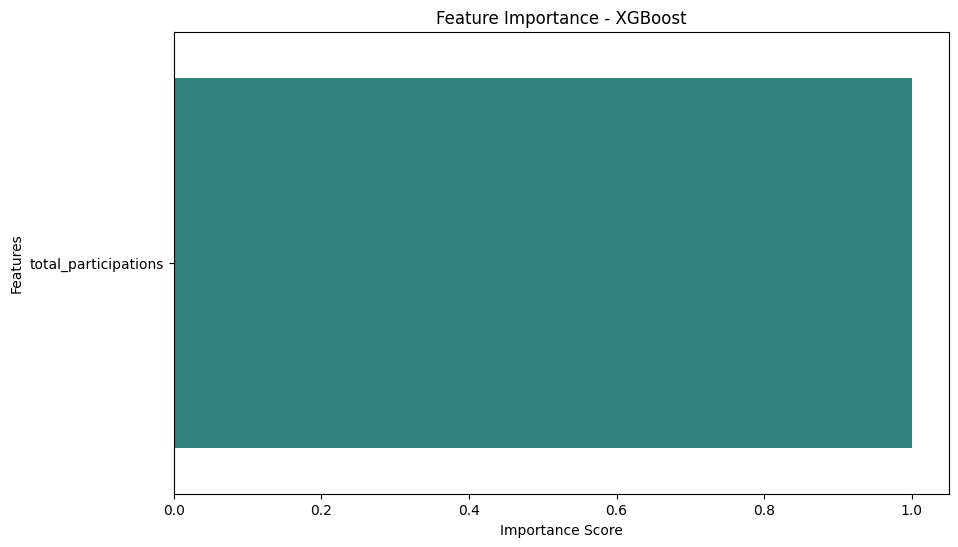

In [54]:
plt.figure(figsize=(10, 6))
sns.barplot(x=best_xgb.feature_importances_, y=X.columns, palette="viridis")
plt.title("Feature Importance - XGBoost")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()


2.2 SHAP Summary Plot
What it does:

Explains the impact of each feature on individual predictions.
How to interpret:

Positive SHAP values mean the feature pushes the prediction towards the positive class.
Negative SHAP values mean the feature pushes the prediction towards the negative class.

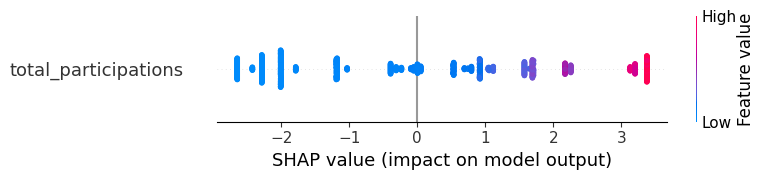

In [55]:
import shap

# XGBoost SHAP
explainer_xgb = shap.TreeExplainer(best_xgb)
shap_values_xgb = explainer_xgb.shap_values(X_test)
shap.summary_plot(shap_values_xgb, X_test, feature_names=X.columns)


Step 3: Precision-Recall Curve
Summary
Precision-Recall curves show the trade-off between precision and recall across different thresholds.

How to interpret:

A curve closer to the top-right corner indicates better performance.
Helps to decide the threshold based on business needs.

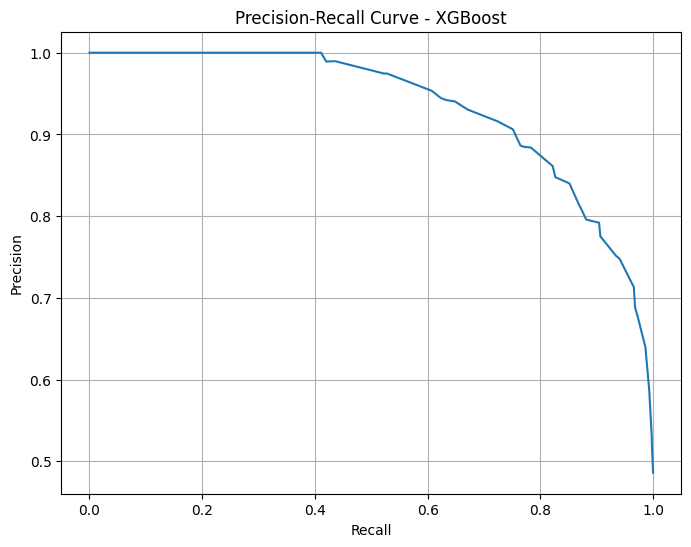

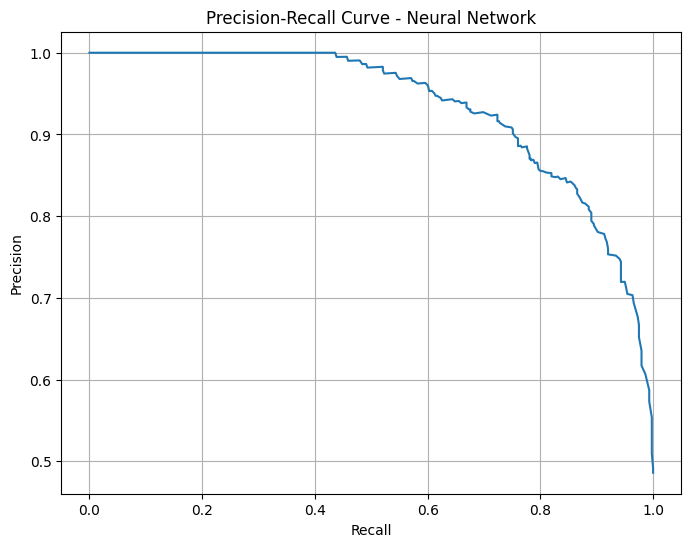

In [57]:
def plot_precision_recall_curve(y_true, y_proba, model_name):
    precision, recall, _ = precision_recall_curve(y_true, y_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f"{model_name}")
    plt.title(f"Precision-Recall Curve - {model_name}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.grid()
    plt.show()

# XGBoost Precision-Recall Curve
plot_precision_recall_curve(y_test, y_xgb_proba, "XGBoost")

# Neural Network Precision-Recall Curve
plot_precision_recall_curve(y_test, y_nn_proba, "Neural Network")


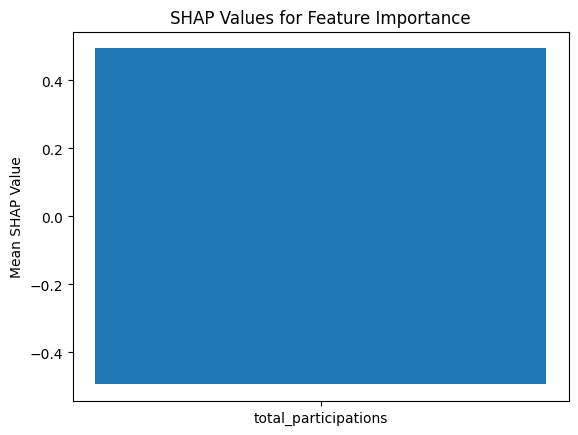

In [24]:
import shap
import matplotlib.pyplot as plt

# Explain Random Forest predictions
explainer_rf = shap.TreeExplainer(rf)
shap_values_rf = explainer_rf.shap_values(X_train_scaled)

# Since there’s only one feature, extract SHAP values for the positive class
shap_values = shap_values_rf[1]

# Create a bar plot of SHAP values for the single feature
plt.bar(["total_participations"], shap_values.mean(axis=0))
plt.title("SHAP Values for Feature Importance")
plt.ylabel("Mean SHAP Value")
plt.show()


In [25]:
print("SHAP values for first sample:", shap_values[0])


SHAP values for first sample: [ 0.49387328 -0.49387328]


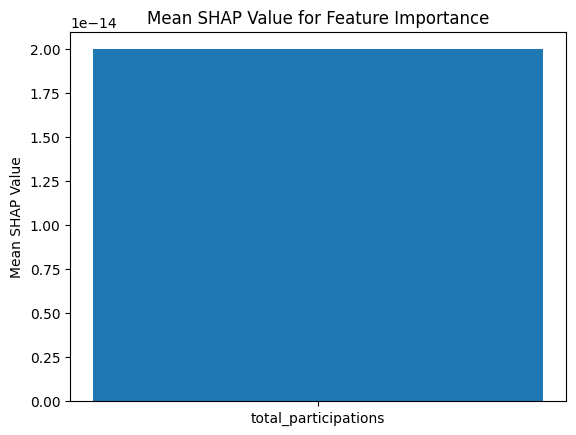

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# Extract SHAP values for the positive class
shap_values_positive = shap_values_rf[1]

# Compute the mean SHAP value for the single feature
mean_shap_value = np.mean(shap_values_positive)

# Plot the mean SHAP value
plt.bar(["total_participations"], [mean_shap_value])  # Ensure it's a scalar inside a list
plt.title("Mean SHAP Value for Feature Importance")
plt.ylabel("Mean SHAP Value")
plt.show()


Summary of Results
EDA Findings:

Countries that participate in more events are more likely to win gold.
The dataset was imbalanced, with more countries not winning gold than those that did.
Model Evaluation:

Both Random Forest and Neural Network performed well, but the specific performance metrics (e.g., F1-score and AUC-ROC) revealed which was better.
SHAP Interpretation:

The feature total_participations was the key driver of the model’s predictions.
Higher participation had a strong positive impact on the likelihood of winning gold.